In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

train_path = "./new_train/new_train/"
val_path = "./new_val_in/new_val_in/"

### Check cuda functionality

In [13]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA GeForce GTX 1060 3GB


### Create a dataset class
Unmodified from the provided `Load_Argoverse_Dataset_Public` notebook

In [14]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data

In [15]:
train_dataset = ArgoverseDataset(data_path = train_path)
val_dataset = ArgoverseDataset(data_path = val_path)

### Exploratory analysis of data

In [ ]:
print('Train keys:')
for key in train_dataset[0].keys():
    print(f'Type of \'{key}\': ', end = '')
    item = train_dataset[0][key]
    print(type(item))
print('\nValidation Keys:')
for key in val_dataset[0].keys():
    print(f'Type of \'{key}\': ', end = '')
    item = train_dataset[0][key]
    print(type(item))

In [ ]:
for key in train_dataset[0].keys():
    item = train_dataset[0][key]
    if type(item) == numpy.ndarray:
        print(f'Size of first 5 instances of \'{key}\': ')
        for i in range(5):
            item = train_dataset[i][key]
            if i == 9:
                print(f'{item.shape}')
            print(f'{item.shape}, ') 
        print()

In [ ]:
x_in = []
y_in = []
x_out = []
y_out = []
vx = []
vy = []
i = 0
for scene in val_dataset:
    for obj in range(int(sum(scene['car_mask']).item())):
        for x1, y1 in scene['p_in'][obj]:
            x_in += [x1]
            y_in += [y1]
        for x1, y1 in scene['v_in'][obj]:
            vx += [x1]
            vy += [y1]
print('Validation set finished. Starting Train set.')
for scene in train_dataset:
    for obj in range(int(sum(scene['car_mask']).item())):
        for x1, y1 in scene['p_in'][obj]:
            x_in += [x1]
            y_in += [y1]
        for x1, y1 in scene['p_out'][obj]:
            x_out += [x1]
            y_out += [y1]
        for x1, y1 in scene['v_in'][obj]:
            vx += [x1]
            vy += [y1]
        for x1, y1 in scene['v_out'][obj]:
            vx += [x1]
            vy += [y1]
    i += 1
    if i % 10000 == 0:
        print(f'{i} scenes finished.')
print('Train set finished.')

In [ ]:
plt.hist2d(x_in, y_in, range = [[-50, 4750], [200, 4100]], bins = 20)
_ = plt.colorbar()

In [ ]:
plt.hist2d(x_out, y_out, range = [[-100, 4800], [550, 4100]], bins = 20)
_ = plt.colorbar()

In [ ]:
plt.hist2d(vx, vy, range = [[-230, 300], [-190, 280]], bins = 20)
_ = plt.colorbar()

In [ ]:
plt.hist2d(vx, vy, range = [[-20, 20], [-20, 20]], bins = 20)
_ = plt.colorbar()

### Create a loader to enable batch processing

In [16]:
batch_sz = 32

def extract_car_ind(tid, track_id):
    for i, idx in enumerate(track_id, 0):
        if tid == idx[0][0]:
            return i

def my_collate(batch):
    inp = [numpy.dstack([scene['p_in'][extract_car_ind(scene['agent_id'], scene['track_id'])], scene['v_in'][extract_car_ind(scene['agent_id'], scene['track_id'])]]) for scene in batch]
    out = [numpy.dstack([scene['p_out'][extract_car_ind(scene['agent_id'], scene['track_id'])]]) for scene in batch]
    inp = torch.Tensor(inp)
    out = torch.Tensor(out)
    return [inp, out]

def my_collate_val(batch):
    inp = [numpy.dstack([scene['p_in'][extract_car_ind(scene['agent_id'], scene['track_id'])], scene['v_in'][extract_car_ind(scene['agent_id'], scene['track_id'])]]) for scene in batch]
    inp = torch.Tensor(inp)
    return inp

In [17]:
tr_loader = DataLoader(train_dataset, batch_size = batch_sz, shuffle = False, collate_fn = my_collate, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size = batch_sz, shuffle = False, collate_fn = my_collate_val, num_workers = 0)

### Create model architecture

In [18]:
def start_pos(x):
    starts = []
    for i in range(x.shape[0]):
        start_x = x[i][0][0][0].item()
        start_y = x[i][0][1][0].item()
        starts += [(start_x, start_y)]
        for j in range(19):
            x[i][j][0][0] -= start_x
            x[i][j][1][0] -= start_y
    return x, starts

def end_pos(x, starts):
    for i in range(x.shape[0]):
        for j in range(30):
            x[i][j][0][0] += starts[i][0]
            x[i][j][1][0] += starts[i][1]
    return x

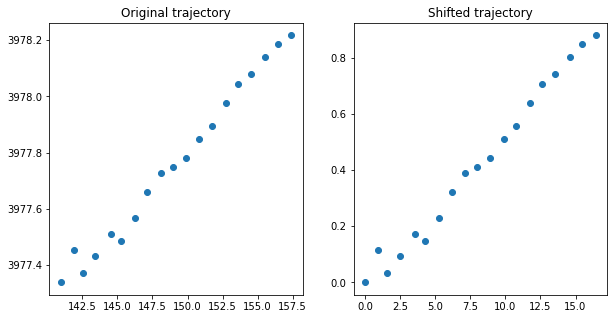

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
b = next(iter(tr_loader))[0]

x = [b[25][i][0][0].item() for i in range(19)]
y = [b[25][i][1][0].item() for i in range(19)]

shifted, _ = start_pos(b)

x1 = [shifted[25][i][0][0].item() for i in range(19)]
y1 = [shifted[25][i][1][0].item() for i in range(19)]

axes[0].scatter(x, y)
axes[0].set_title('Original trajectory')
axes[1].scatter(x1, y1)
_ = axes[1].set_title('Shifted trajectory')

In [20]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(2, 64)
        self.bn1 = nn.BatchNorm2d(19)
        self.fc2 = nn.Linear(64, 256)
        self.conv1 = nn.Conv2d(19, 512, 1)
        self.fc3 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm2d(512)
        self.ln = nn.InstanceNorm2d(512, affine = True)
        self.fc4 = nn.Linear(128, 64)
        self.conv2 = nn.Conv2d(512, 128, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 30, 1)
        self.fc5 = nn.Linear(64, 1)
        
    def forward(self, x):
        x, starts = start_pos(x)
        x = self.fc1(x)
        x = F.log_softmax(self.bn1(x), dim = 1)
        x = self.fc2(x)
        x = self.conv1(x)
        x = self.fc3(x)
        x = F.log_softmax(self.ln(x), dim = 1)
        x = F.log_softmax(self.bn2(x), dim = 1)        
        x = self.fc4(x)
        x = self.conv2(x)
        x = F.log_softmax(self.bn3(x), dim = 1)
        x = self.conv3(x)
        x = self.fc5(x)
        return end_pos(x, starts)

In [109]:
device = 'cuda'
batch_sz = 32

tr_loader = DataLoader(train_dataset, batch_size = batch_sz, shuffle = False, collate_fn = my_collate, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size = batch_sz, shuffle = False, collate_fn = my_collate_val, num_workers = 0)

net = Model().to(device)
optimizers = [optim.Adagrad, optim.Adam, optim.ASGD, optim.RMSprop, optim.SGD]
criterion = nn.MSELoss(reduction = 'mean').to(device)

e = 5
p = len(tr_loader) // 100
# p = 2
losses = []

for o in range(5):
    net = Model().to(device)
    if o < 3:
        optimizer = optimizers[o](net.parameters(), lr = 0.0001)
    else:
        optimizer = optimizers[o](net.parameters(), lr = 0.0001, momentum = 0.9)
    criterion = nn.MSELoss(reduction = 'mean').to(device)
    l = []
    l_mini = []
    net.train()
    for epoch in range(e):
        running_loss = 0.0
        total_loss = 0.0
        for i, data in enumerate(tr_loader, 0):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            try:
                outputs = net(inputs)
            except RuntimeError:
                print('!')
                continue
            loss = torch.sqrt(criterion(outputs, targets))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total_loss += loss.item()
            if i % p == p - 1:
                l_mini += [running_loss / p]
                print('[%d, %5d] loss %.3f' %
                      (epoch + 1, i + 1, running_loss / p))
                running_loss = 0.0
            if i == 10 * p - 1:
                break
        print(f'End of epoch {epoch + 1}   loss {total_loss / (i + 1)}')
        l += [total_loss / (i + 1)]
    print('Finished Training')
    losses += [l]

[1,    64] loss 22.833
[1,   128] loss 20.828
[1,   192] loss 19.705
[1,   256] loss 18.575
[1,   320] loss 18.860
[1,   384] loss 18.348
[1,   448] loss 17.631
[1,   512] loss 17.131
[1,   576] loss 17.127
[1,   640] loss 16.610
End of epoch 1   loss 18.764742013812064
[2,    64] loss 16.744
[2,   128] loss 16.390
[2,   192] loss 16.216
[2,   256] loss 15.666
[2,   320] loss 16.276
[2,   384] loss 15.963
[2,   448] loss 15.502
[2,   512] loss 15.121
[2,   576] loss 15.209
[2,   640] loss 14.769
End of epoch 2   loss 15.785707299411296
[3,    64] loss 14.966
[3,   128] loss 14.715
[3,   192] loss 14.624
[3,   256] loss 14.132
[3,   320] loss 14.774
[3,   384] loss 14.504
[3,   448] loss 14.083
[3,   512] loss 13.745
[3,   576] loss 13.856
[3,   640] loss 13.446
End of epoch 3   loss 14.284527784585952
[4,    64] loss 13.661
[4,   128] loss 13.439
[4,   192] loss 13.373
[4,   256] loss 12.913
[4,   320] loss 13.565
[4,   384] loss 13.322
[4,   448] loss 12.926
[4,   512] loss 12.630
[4,

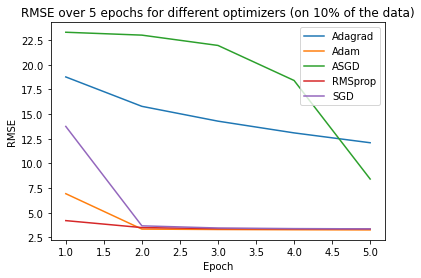

In [121]:
plt.plot(range(1, 6), losses[0], label = 'Adagrad')
plt.plot(range(1, 6), losses[1], label = 'Adam')
plt.plot(range(1, 6), losses[2], label = 'ASGD')
plt.plot(range(1, 6), losses[3], label = 'RMSprop')
plt.plot(range(1, 6), losses[4], label = 'SGD')
plt.legend()
plt.title('RMSE over 5 epochs for different optimizers (on 10% of the data)')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

### Set up model and parameters

In [24]:
device = 'cuda'
batch_sz = 32

tr_loader = DataLoader(train_dataset, batch_size = batch_sz, shuffle = False, collate_fn = my_collate, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size = batch_sz, shuffle = False, collate_fn = my_collate_val, num_workers = 0)

net = Model().to(device)
optimizer = optim.RMSprop(net.parameters(), lr = 0.0001, momentum = 0.9)
criterion = nn.MSELoss(reduction = 'mean').to(device)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.1)

In [25]:
sum(p.numel() for p in net.parameters())

140165

### Train model

In [116]:
e = 10
# p = len(tr_loader) // 10
p = 10
l = []
l_mini = []

net.train()
for epoch in range(e):
#     print(scheduler.get_lr())
#     if (epoch % 2 == 0) and epoch != 0:
#         scheduler.step()
    running_loss = 0.0
    total_loss = 0.0
    for i, data in enumerate(tr_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        try:
            outputs = net(inputs)
        except RuntimeError:
            print('!')
            continue
        loss = torch.sqrt(criterion(outputs, targets))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        total_loss += loss.item()
        if i % p == p - 1:
            l_mini += [running_loss / p]
            print('[%d, %5d] loss %.3f' %
                  (epoch + 1, i + 1, running_loss / p))
            running_loss = 0.0
        if i == 10 * p - 1:
            break
    print(f'End of epoch {epoch + 1}   loss {total_loss / (i + 1)}')
    l += [total_loss / (i + 1)]
print('Finished Training')

[1,    10] loss 22.753
[1,    20] loss 23.457
[1,    30] loss 23.567
[1,    40] loss 23.924
[1,    50] loss 23.095
[1,    60] loss 24.304
[1,    70] loss 23.934
[1,    80] loss 22.382
[1,    90] loss 22.427
[1,   100] loss 23.227
End of epoch 1   loss 23.306969356536865
[2,    10] loss 22.752
[2,    20] loss 23.456
[2,    30] loss 23.566
[2,    40] loss 23.924
[2,    50] loss 23.094
[2,    60] loss 24.304
[2,    70] loss 23.933
[2,    80] loss 22.381
[2,    90] loss 22.427
[2,   100] loss 23.227
End of epoch 2   loss 23.306495552062987
[3,    10] loss 22.752
[3,    20] loss 23.456
[3,    30] loss 23.566
[3,    40] loss 23.924
[3,    50] loss 23.093
[3,    60] loss 24.305
[3,    70] loss 23.932
[3,    80] loss 22.381
[3,    90] loss 22.427
[3,   100] loss 23.227
End of epoch 3   loss 23.306118087768553
[4,    10] loss 22.751
[4,    20] loss 23.456
[4,    30] loss 23.565
[4,    40] loss 23.923
[4,    50] loss 23.092
[4,    60] loss 24.305
[4,    70] loss 23.932
[4,    80] loss 22.380
[4,

### Visualize Loss

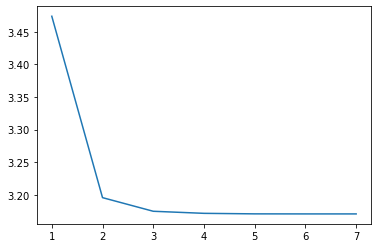

In [29]:
_ = plt.plot(range(1, 8), l)

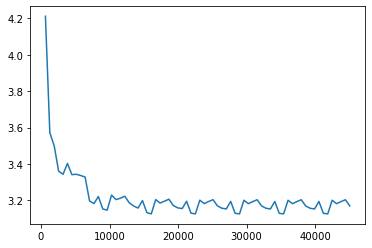

In [30]:
x = []
for e in range(7):
    for p in range(len(tr_loader) // 10, len(tr_loader), len(tr_loader) // 10):
        x += [e * len(tr_loader) + p]
_ = plt.plot(x, l_mini)

### Visualize Predictions

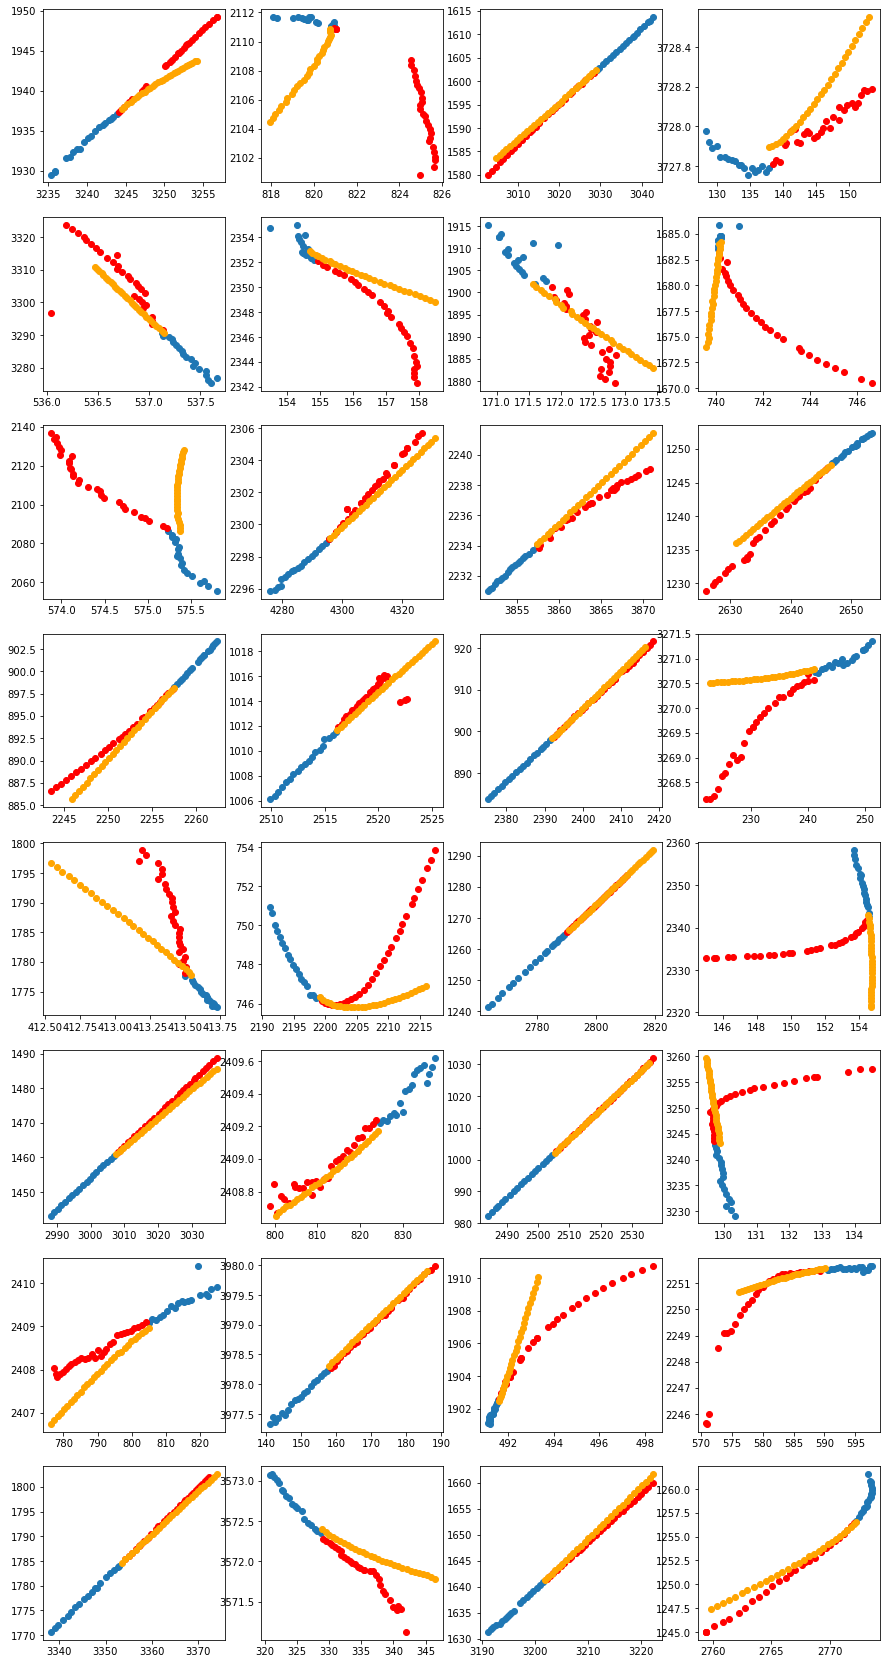

In [31]:
inp, target = next(iter(tr_loader))
with torch.no_grad():
    net.eval()
    out = net(inp.to(device))
fig, axes = plt.subplots(8, 4, figsize = (15, 30))
for i in range(8):
    for j in range(4):
        x_in = [inp[4 * i + j][k][0][0].item() for k in range(19)]
        y_in = [inp[4 * i + j][k][1][0].item() for k in range(19)]
        x_true_out = [target[4 * i + j][k][0].item() for k in range(30)]
        y_true_out = [target[4 * i + j][k][1].item() for k in range(30)]
        x_out = [out[4 * i + j][k][0].item() for k in range(30)]
        y_out = [out[4 * i + j][k][1].item() for k in range(30)]

        axes[i, j].scatter(x_in, y_in)
        axes[i, j].scatter(x_true_out, y_true_out, c = 'red')
        axes[i, j].scatter(x_out, y_out, c = 'orange')

### Write predictions to csv

In [32]:
cols = ['ID']
for i in range(1, 61):
    cols += ['v' + str(i)]

l = []
j = 0
net.eval()
for inputs in val_loader:
    with torch.no_grad():
        out = net(inputs.to(device))
    for scene in out:
        row = [val_dataset[j]['scene_idx']]
        j += 1
        for i in range(30):
            row += [scene[i][0].item()]
            row += [scene[i][1].item()]
        l += [row]
df = pd.DataFrame(l, columns = cols)

df.to_csv('submission.csv', index = False)